In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

In [33]:
###1
# 1. 데이터 불러오기
df = pd.read_csv("train.csv")
# 2. 불필요한 열 제거
df = df.drop(columns=['id', 'CustomerId', 'Surname'])

# 3. 범주형 변수 원-핫 인코딩
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# 4. 입력(X), 타겟(y) 분리
X = df.drop(columns=['Exited'])
y = df['Exited']

# 5. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 6. 학습용/검증용 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 7. XGBoost 분류기 정의 및 학습
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# 8. 검증용 데이터 예측 (확률 예측)
y_valid_pred = model.predict_proba(X_valid)[:, 1]

# 9. AUC 평가 출력
auc_score = roc_auc_score(y_valid, y_valid_pred)
print("검증 데이터 ROC AUC 점수:", round(auc_score, 4))

검증 데이터 ROC AUC 점수: 0.8908


In [34]:
# 1. train 데이터 불러오기 및 전처리
train_df = pd.read_csv("train.csv")
train_df = train_df.drop(columns=['id', 'CustomerId', 'Surname'])
train_df = pd.get_dummies(train_df, columns=['Geography', 'Gender'], drop_first=True)

# X, y 분리
y = train_df['Exited']
X = train_df.drop(columns=['Exited'])

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# XGBoost 모델 학습
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_scaled, y)

# 2. test 데이터 불러오기 및 전처리
test_df = pd.read_csv("test.csv")
test_ids = test_df['id']  # 결과에 포함시킬 id 저장
test_df = test_df.drop(columns=['id', 'CustomerId', 'Surname'])
test_df = pd.get_dummies(test_df, columns=['Geography', 'Gender'], drop_first=True)

# 컬럼 정렬 (train과 같은 순서로 맞추기)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# 스케일링 적용
X_test_scaled = scaler.transform(test_df)

# 3. 예측
test_preds = model.predict_proba(X_test_scaled)[:, 1]

# 4. 제출 파일 생성
submission = pd.DataFrame({
    "id": test_ids,
    "Exited": test_preds
})
submission.to_csv("submission.csv", index=False)
print("submission.csv 생성")


submission.csv 생성


In [45]:
###2
# 데이터 불러오기 및 전처리
df = pd.read_csv("train.csv")
df = df.drop(columns=["id", "CustomerId", "Surname"])
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)

X = df.drop(columns=["Exited"])
y = df["Exited"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [3.5]
}

# 모델 정의
model = XGBClassifier(eval_metric='logloss', random_state=42)

# GridSearchCV 설정
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 모델 학습
grid.fit(X_scaled, y)

# 최적 결과 출력
print("Best ROC AUC:", round(grid.best_score_, 5))
print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best ROC AUC: 0.88963
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 3.5, 'subsample': 0.8}


In [36]:
# 1. 학습 데이터 불러오기 및 전처리
train_df = pd.read_csv("train.csv")
train_df = train_df.drop(columns=["id", "CustomerId", "Surname"])
train_df = pd.get_dummies(train_df, columns=["Geography", "Gender"], drop_first=True)

X = train_df.drop(columns=["Exited"])
y = train_df["Exited"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 최적 파라미터로 모델 생성 및 학습
model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    scale_pos_weight=3.5,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_scaled, y)

# 3. 테스트 데이터 불러오기 및 전처리
test_df = pd.read_csv("test.csv")
test_ids = test_df["id"]
test_df = test_df.drop(columns=["id", "CustomerId", "Surname"])
test_df = pd.get_dummies(test_df, columns=["Geography", "Gender"], drop_first=True)

# 컬럼 순서 맞추기
test_df = test_df.reindex(columns=X.columns, fill_value=0)
X_test_scaled = scaler.transform(test_df)

# 4. 예측 및 제출 파일 저장
y_pred = model.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    "id": test_ids,
    "Exited": y_pred
})

submission.to_csv("submission2.csv", index=False)
print("submission2.csv 생성")



submission2.csv 생성


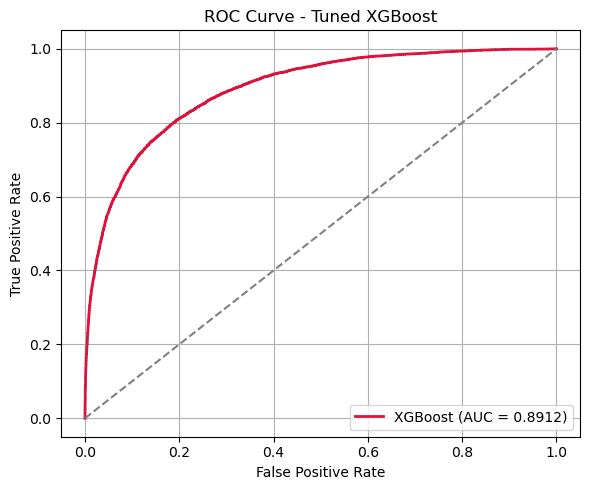

<Figure size 800x600 with 0 Axes>

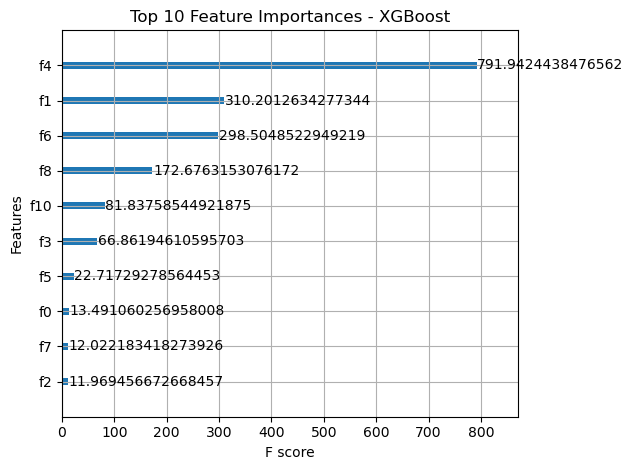

In [50]:
# ROC Curve 시각화
y_valid_prob = xgb_model.predict_proba(X_valid_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_valid, y_valid_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='crimson', lw=2, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance 시각화
plt.figure(figsize=(8, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()


In [38]:
###3

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv("train.csv")
df = df.drop(columns=["id", "CustomerId", "Surname"])
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)

X = df.drop(columns=["Exited"])
y = df["Exited"]

# 2. 학습/검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# 4. 개별 모델 정의 (튜닝된 XGBoost 포함)
xgb_clf = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    scale_pos_weight=3.5,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
log_clf = LogisticRegression(max_iter=1000, random_state=42)

# 5. 앙상블 모델 구성
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('lr', log_clf)
    ],
    voting='soft',  # 확률 평균 방식
    n_jobs=1        # 메모리 부족 방지용
)

# 6. 학습 및 예측
voting_clf.fit(X_train_scaled, y_train)
y_valid_pred = voting_clf.predict_proba(X_valid_scaled)[:, 1]

# 7. AUC 출력
auc = roc_auc_score(y_valid, y_valid_pred)
print("앙상블 모델 ROC AUC 점수:", round(auc, 5))


앙상블 모델 ROC AUC 점수: 0.88585


In [39]:
# 4. 테스트 데이터 불러오기 및 전처리
test_df = pd.read_csv("test.csv")
test_ids = test_df["id"]
test_df = test_df.drop(columns=["id", "CustomerId", "Surname"])
test_df = pd.get_dummies(test_df, columns=["Geography", "Gender"], drop_first=True)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

X_test_scaled = scaler.transform(test_df)

# 5. 예측 및 제출 파일 저장
y_pred = voting_clf.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    "id": test_ids,
    "Exited": y_pred
})
submission.to_csv("submission3.csv", index=False)
print("앙상블 기반 submission3.csv 생성")

앙상블 기반 submission3.csv 생성


In [40]:
###4

# 데이터 로드 및 전처리
df = pd.read_csv("train.csv")
df = df.drop(columns=["id", "CustomerId", "Surname"])
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)

X = df.drop(columns=["Exited"])
y = df["Exited"]

# train/validation 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# RandomForest 튜닝
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)

# LogisticRegression 튜닝
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_grid = GridSearchCV(lr, lr_param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
lr_grid.fit(X_train_scaled, y_train)

# 최적 파라미터 출력
print("RandomForest Best AUC:", round(rf_grid.best_score_, 5))
print("Best RF Params:", rf_grid.best_params_)

print("LogisticRegression Best AUC:", round(lr_grid.best_score_, 5))
print("Best LR Params:", lr_grid.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
RandomForest Best AUC: 0.88713
Best RF Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
LogisticRegression Best AUC: 0.8177
Best LR Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [41]:


# 1. train 데이터 로드 및 전처리
train_df = pd.read_csv("train.csv")
train_df = train_df.drop(columns=["id", "CustomerId", "Surname"])
train_df = pd.get_dummies(train_df, columns=["Geography", "Gender"], drop_first=True)

X = train_df.drop(columns=["Exited"])
y = train_df["Exited"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 각 모델 정의 (튜닝된 하이퍼파라미터 반영)
xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    scale_pos_weight=3.5,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=2,
    random_state=42
)

lr_model = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# 3. 앙상블 모델 구성 (VotingClassifier)
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    voting='soft',
    n_jobs=1
)

# 4. 전체 데이터로 학습
ensemble.fit(X_scaled, y)

# 5. test.csv 불러오기 및 전처리
test_df = pd.read_csv("test.csv")
test_ids = test_df["id"]
test_df = test_df.drop(columns=["id", "CustomerId", "Surname"])
test_df = pd.get_dummies(test_df, columns=["Geography", "Gender"], drop_first=True)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

X_test_scaled = scaler.transform(test_df)

# 6. 예측 및 제출 파일 저장
y_pred = ensemble.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    "id": test_ids,
    "Exited": y_pred
})
submission.to_csv("submission4.csv", index=False)
print("튜닝된 앙상블 기반 submission4.csv 생성")


튜닝된 앙상블 기반 submission4.csv 생성
